# __Scenario B:__<br>$\alpha$-glucosidase inhibition by fucoidan

Data provided by Chantal Daub (Biochemistry, Rhodes University, Makhanda, South Africa)

## Project background
In this scenario, the inhibitory properties of fucoidan, a polysaccharide found in brown algae, on $\alpha$-glucosidase from *Saccharomyces cerevisiae* was investigated. Fucoidans are actively investigated in the fields of anit-cancer, anti-inflammation, and anti-coagulate, to name a fiew ({cite:t}`li2008fucoidan`). In a previous study ({cite:t}`daub2020fucoidan`), fucoidan from *E. maxima* showed an almost 2-fold lower IC<sub>50</sub> value, compared to acarbose. Thus, fucoidan is a potential antidiabetic drug candidate for the treatment of diabetes mellitus.
In the following analysis, fucoidan from the brown algae species *Ecklonia maxima*, *Ecklonia radiata*, *Fucus vesiculosus*, S. CYM???????, and *Schimmelmannia elegans* were investigated for their inhibition constant $K_{i}$ for $\alpha$-glucosidase inhibition.

## Experimental design 

Extracted fucoidan from the mentioned brown algea species was applied in two different concentrations to enzyme reactions. Additionally, control reactions without inhibitor were performed. For the enzyme reactions, *p*-nitrophenyl-$\alpha$-D-glucopyranoside (pNPG) was applied as a substrate in a concentration range from 0.1 - 5 mM. Product accumulatin was followed photometrically in a micro titer plate at 405 nm for 20 min.

## Data preparation

### Imports

In [1]:
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
import os
import pyenzyme as pe
from CaliPytion.tools.standardcurve import StandardCurve
from EnzymePynetics.tools.parameterestimator import ParameterEstimator


import warnings
warnings.filterwarnings('ignore')

colors = list(mcolors.TABLEAU_COLORS.values())

### Experimental data
Time-course data of all kinetic experiments was collected in an Excel file, whereas the meta data was specified in individual EnzymeML Excel templates for each origin species of fucoidan. In the following cell the experimental data is loaded and blanked to subtract the absorbance contribution of enzyme, buffer, and the respective inhibitor for each measurement. Thereafter, the data is written to EnzymeML documents.

In [2]:
dataset_path = "../../data/glucosidase_inhibition/experimental_data.xlsx"
template_directory = "../../data/glucosidase_inhibition/EnzymeML_templates"   

inhibitors = sorted(pd.ExcelFile(dataset_path).sheet_names)
initial_substrates = [0.1, 0.25, 0.5, 1, 2.5, 5]


data_dict = {}
for inhibitor in inhibitors:
    df = pd.read_excel(dataset_path, sheet_name=inhibitor).set_index("time")
    blanc_no_inhibitor = df["buffer + enzyme"].mean()
    blank_low_inhibitor = df[df.columns[[1,2]]].values.mean()
    blank_high_inhibitor = df[df.columns[[3,4]]].values.mean()
    df = df.iloc[:,17:]
    keys = sorted(df.columns)
    df_no_inhibitor = df[keys[:12]]
    df_low_inhibitor = df[keys[12:24]]
    df_high_inhibitor = df[keys[24:]]

    df_no_inhibitor = df_no_inhibitor.subtract(blanc_no_inhibitor)
    df_low_inhibitor = df_low_inhibitor.subtract(blank_low_inhibitor)
    df_high_inhibitor = df_high_inhibitor.subtract(blank_high_inhibitor)


    data = []
    data.append(df_no_inhibitor.values.T)
    data.append(df_low_inhibitor.values.T)
    data.append(df_high_inhibitor.values.T)

    data_dict[inhibitor] = np.array(data).reshape(18,2,20)

time = df.index.values

# Parse measurement data to EnzymeML documents
def measurement_data_to_EnzymeML(
    template_path: str,
    measurement_data: np.ndarray,
    species_id: str,
    time: np.ndarray,
    data_unit: str,
    time_unit: str
    ) -> pe.EnzymeMLDocument:

    enzmldoc: pe.EnzymeMLDocument = pe.EnzymeMLDocument.fromTemplate(template_path)

    for IDs, concentration in zip(enzmldoc.measurement_dict.keys(), measurement_data):
        for counter, replicate in enumerate(concentration):
            
            enzmldoc.getMeasurement(IDs).addReplicates(pe.Replicate(
                id=f"Measurement{counter}",
                species_id=species_id,
                data=list(replicate),
                data_unit=data_unit,
                time=list(time),
                time_unit=time_unit), enzmldoc)

    return enzmldoc

enzml_docs = []
datas = list(data_dict.values())
for file, data in zip(sorted(os.listdir(template_directory)), datas):
    enzml_docs.append(measurement_data_to_EnzymeML(
        template_path=f"{template_directory}/{file}",
        measurement_data=data,
        time=time,
        species_id="s1",
        data_unit="mmole / l",
        time_unit="min"
    ))

### Concentration calculation

Standard data of the product was loaded from an excel file, and a standard curve was created. Then, the standard curve was applied to the EnzymeML documents, containing the absorption measurements for concentration calculation.

Calibration data was automatically blanked.


,AIC
3rd polynominal,-135
Quadratic,-135
Rational,-135
Linear,-125
Exponential,-11


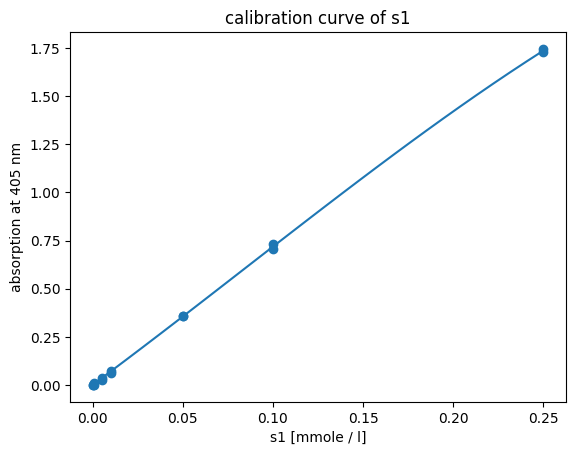

In [3]:
path_calibration_data = "../../data/glucosidase_inhibition/p-NP_standard.xlsx"


product_standard = StandardCurve.from_excel(
    path=path_calibration_data,
    reactant_id="s1", 
    sheet_name="csv", 
    wavelength=405, 
    concentration_unit = "mmole / l", 
    cutoff_absorption=2)

product_standard.visualize()

# Apply calibration curves to absorption EnzymeML documents
for enzmldoc in enzml_docs:
    product_standard.apply_to_EnzymeML(enzmldoc, "s1")

### Parameter estimation

Parameter estimation was perfomed with EnzymePynetics. Thereby, each data set was fitted to competitive, uncompetitive, and non-competitive inhibition models.

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive product inhibition model
 - uncompetitive product inhibition model
 - non-competitive product inhibition model
 - substrate inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
non-competitive product inhibition,-2257,2480.867 +/- 10.41%,0.545 +/- 19.96%,4554.048 +/- 22.51%,0.040 +/- 24.85%,0.249 +/- 34.07%
competitive product inhibition,-2243,1756.430 +/- 2.72%,0.286 +/- 15.37%,6132.817 +/- 15.61%,0.027 +/- 25.68%,-
uncompetitive product inhibition,-2187,2912.596 +/- 14.85%,1.432 +/- 17.61%,2034.270 +/- 23.03%,-,0.108 +/- 29.22%
irreversible Michaelis Menten,-2146,1429.827 +/- 1.55%,0.603 +/- 4.92%,2372.038 +/- 5.16%,-,-
substrate inhibition,-2139,1455.278 +/- 1.73%,0.623 +/- 5.31%,2334.831 +/- 5.59%,-,248.634 +/- 61.85%


Fit report for non-competitive product inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 237
    # variables        = 4
    chi-square         = 0.01676347
    reduced chi-square = 7.1946e-05
    Akaike info crit   = -2256.91734
    Bayesian info crit = -2243.04510
[[Variables]]
    k_cat:  2480.86683 +/- 258.151536 (10.41%) (init = 3652.667)
    Km:     0.54476083 +/- 0.10872800 (19.96%) (init = 1.6784)
    K_iu:   0.24899154 +/- 0.08483063 (34.07%) (init = 0.1)
    K_ic:   0.04004974 +/- 0.00995050 (24.85%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_iu) = -0.964
    C(Km, K_iu)    = -0.808
    C(Km, K_ic)    = 0.771
    C(k_cat, Km)   = 0.731
    C(K_iu, K_ic)  = -0.324
    C(k_cat, K_ic) = 0.150


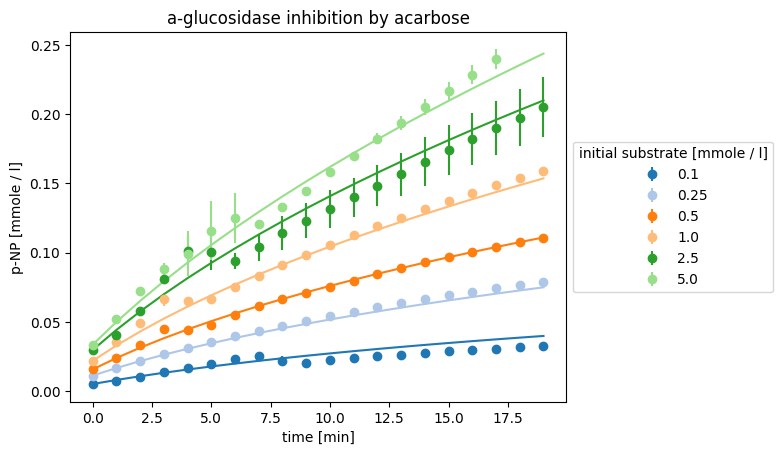

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
non-competitive inhibition,-6142,1639.222 +/- 1.65%,0.552 +/- 5.44%,2971.298 +/- 5.68%,0.109 +/- 10.27%,0.602 +/- 10.61%
competitive inhibition,-6055,1610.235 +/- 1.73%,0.526 +/- 5.80%,3062.265 +/- 6.05%,0.052 +/- 5.48%,-
partially competitive inhibition,-6053,1610.208 +/- 1.74%,0.526 +/- 5.80%,3062.405 +/- 6.05%,0.052 +/- 5.75%,1000.000 +/- 3817.44%
uncompetitive inhibition,-5819,1746.747 +/- 2.21%,0.742 +/- 6.49%,2353.001 +/- 6.86%,-,0.214 +/- 4.57%
irreversible Michaelis Menten,-4753,945.417 +/- 5.07%,0.809 +/- 15.18%,1168.173 +/- 16.00%,-,-


Fit report for non-competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 717
    # variables        = 4
    chi-square         = 0.13495950
    reduced chi-square = 1.8928e-04
    Akaike info crit   = -6142.32304
    Bayesian info crit = -6124.02274
[[Variables]]
    k_cat:  1639.22182 +/- 27.1273263 (1.65%) (init = 4965.792)
    Km:     0.55168535 +/- 0.03000408 (5.44%) (init = 2.281781)
    K_iu:   0.60181800 +/- 0.06386257 (10.61%) (init = 0.1)
    K_ic:   0.10943768 +/- 0.01123454 (10.27%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km)   = 0.822
    C(K_iu, K_ic)  = -0.765
    C(Km, K_ic)    = 0.469
    C(k_cat, K_ic) = 0.322
    C(k_cat, K_iu) = -0.306
    C(Km, K_iu)    = -0.253


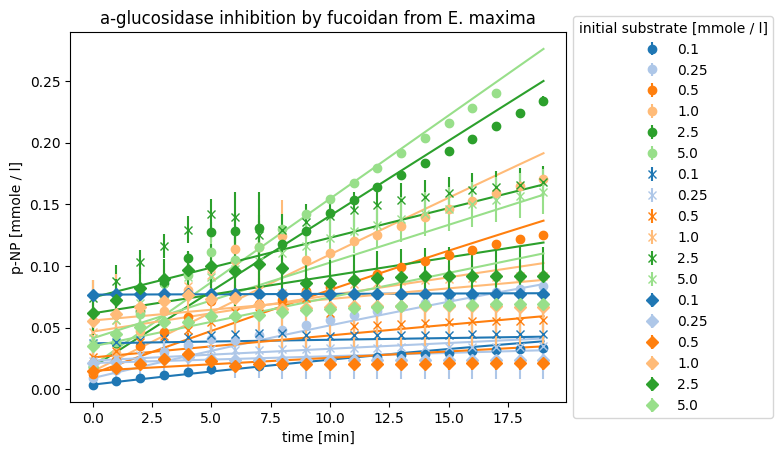

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
partially competitive inhibition,-7058,1075.485 +/- 1.11%,0.478 +/- 3.97%,2252.123 +/- 4.12%,0.000 +/- 271.89%,0.001 +/- 728.83%
non-competitive inhibition,-6658,1059.810 +/- 1.56%,0.483 +/- 5.51%,2194.677 +/- 5.73%,0.017 +/- 7.98%,0.789 +/- 48.63%
competitive inhibition,-6656,1046.201 +/- 1.46%,0.464 +/- 5.32%,2253.506 +/- 5.52%,0.015 +/- 5.33%,-
uncompetitive inhibition,-6260,1291.208 +/- 2.47%,1.151 +/- 6.12%,1121.648 +/- 6.60%,-,0.065 +/- 5.45%
irreversible Michaelis Menten,-5818,921.806 +/- 2.90%,1.070 +/- 8.06%,861.615 +/- 8.57%,-,-


Fit report for partially competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 272
    # data points      = 720
    # variables        = 4
    chi-square         = 0.03936609
    reduced chi-square = 5.4981e-05
    Akaike info crit   = -7058.15327
    Bayesian info crit = -7039.83626
[[Variables]]
    k_cat:  1075.48537 +/- 11.8902583 (1.11%) (init = 1620.85)
    Km:     0.47754289 +/- 0.01896377 (3.97%) (init = 0.7447807)
    K_iu:   6.1448e-04 +/- 0.00447849 (728.83%) (init = 0.1)
    K_ic:   1.0000e-04 +/- 2.7189e-04 (271.89%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(K_iu, K_ic) = -1.000
    C(k_cat, Km)  = 0.779


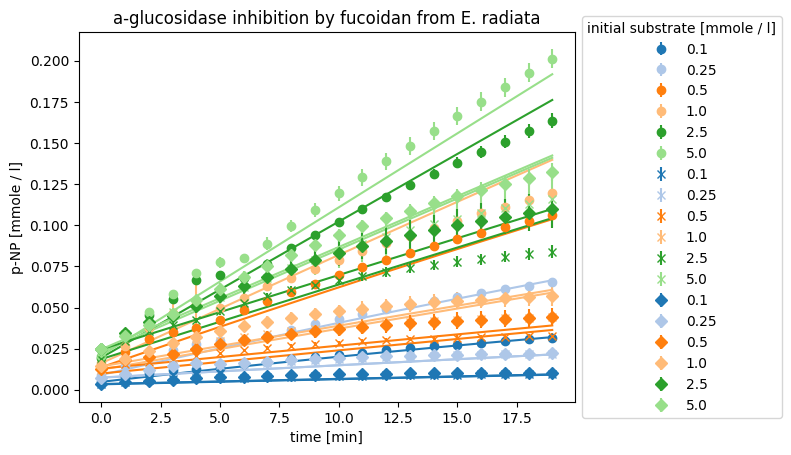

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
competitive inhibition,-7326,1527.487 +/- 0.99%,0.938 +/- 2.87%,1628.994 +/- 3.04%,0.001 +/- 4.85%,-
non-competitive inhibition,-7324,1527.536 +/- 0.99%,0.938 +/- 2.88%,1628.803 +/- 3.04%,0.001 +/- 14.89%,15.494 +/- 36228.16%
partially competitive inhibition,-7324,1527.908 +/- 0.99%,0.939 +/- 2.88%,1627.963 +/- 3.04%,0.001 +/- 7.82%,999.141 +/- 139876.39%
uncompetitive inhibition,-7028,1531.314 +/- 1.22%,0.947 +/- 3.53%,1616.521 +/- 3.74%,-,0.002 +/- 7.52%
irreversible Michaelis Menten,-4775,667.025 +/- 10.33%,1.455 +/- 26.07%,458.453 +/- 28.04%,-,-


Fit report for competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 720
    # variables        = 3
    chi-square         = 0.02722244
    reduced chi-square = 3.7967e-05
    Akaike info crit   = -7325.73480
    Bayesian info crit = -7311.99704
[[Variables]]
    k_cat:  1527.48678 +/- 15.1025514 (0.99%) (init = 2691.849)
    Km:     0.93768696 +/- 0.02693290 (2.87%) (init = 1.236905)
    K_ic:   0.00134723 +/- 6.5379e-05 (4.85%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km)   = 0.865
    C(Km, K_ic)    = 0.407
    C(k_cat, K_ic) = 0.294


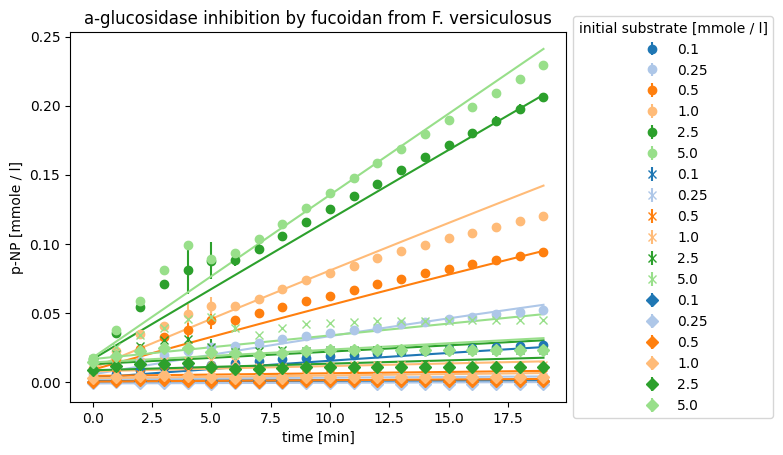

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
partially competitive inhibition,-7611,885.193 +/- 0.65%,0.431 +/- 2.76%,2051.891 +/- 2.83%,0.175 +/- 28.00%,0.452 +/- 36.06%
non-competitive inhibition,-7574,900.852 +/- 0.92%,0.471 +/- 3.29%,1914.077 +/- 3.41%,0.966 +/- 7.73%,21.519 +/- 37.84%
competitive inhibition,-7568,885.729 +/- 0.67%,0.448 +/- 2.79%,1979.019 +/- 2.87%,0.841 +/- 5.36%,-
uncompetitive inhibition,-7324,975.489 +/- 1.06%,0.710 +/- 2.69%,1373.348 +/- 2.89%,-,3.737 +/- 6.80%
irreversible Michaelis Menten,-7096,874.452 +/- 0.94%,0.652 +/- 3.01%,1340.611 +/- 3.16%,-,-


Fit report for partially competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 124
    # data points      = 720
    # variables        = 4
    chi-square         = 0.01825580
    reduced chi-square = 2.5497e-05
    Akaike info crit   = -7611.41698
    Bayesian info crit = -7593.09998
[[Variables]]
    k_cat:  885.192687 +/- 5.78448532 (0.65%) (init = 1279.274)
    Km:     0.43140343 +/- 0.01189835 (2.76%) (init = 0.5878264)
    K_iu:   0.45219052 +/- 0.16305078 (36.06%) (init = 0.1)
    K_ic:   0.17451878 +/- 0.04887071 (28.00%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(K_iu, K_ic) = 0.994
    C(k_cat, Km)  = 0.671
    C(Km, K_ic)   = 0.146


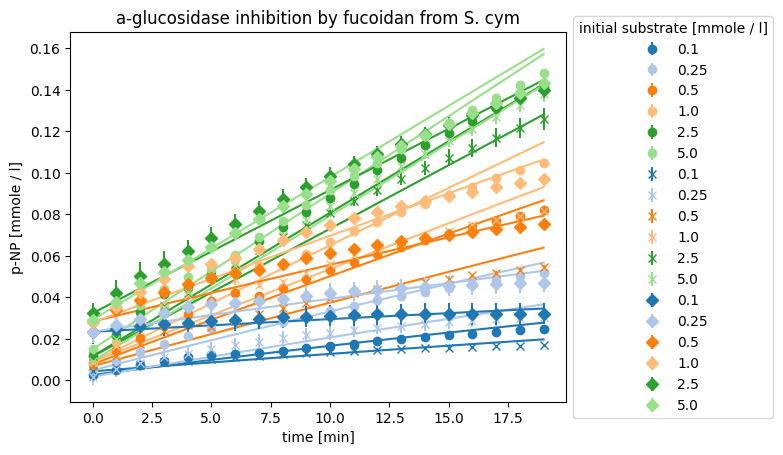

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive inhibition model
 - uncompetitive inhibition model
 - non-competitive inhibition model
 - partially competitive inhibition model


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
non-competitive inhibition,-7110,1196.091 +/- 1.22%,0.693 +/- 3.86%,1724.867 +/- 4.04%,0.008 +/- 6.67%,0.272 +/- 39.90%
competitive inhibition,-7106,1191.620 +/- 1.21%,0.686 +/- 3.85%,1736.014 +/- 4.04%,0.007 +/- 3.65%,-
partially competitive inhibition,-7104,1191.646 +/- 1.21%,0.686 +/- 3.86%,1735.964 +/- 4.04%,0.007 +/- 9.27%,999.732 +/- 110814.71%
uncompetitive inhibition,-6381,1334.869 +/- 2.31%,1.095 +/- 6.22%,1218.643 +/- 6.63%,-,0.021 +/- 4.53%
irreversible Michaelis Menten,-5320,837.262 +/- 6.08%,1.586 +/- 14.95%,527.980 +/- 16.14%,-,-


Fit report for non-competitive inhibition model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 720
    # variables        = 4
    chi-square         = 0.03661395
    reduced chi-square = 5.1137e-05
    Akaike info crit   = -7110.33552
    Bayesian info crit = -7092.01851
[[Variables]]
    k_cat:  1196.09080 +/- 14.5632835 (1.22%) (init = 1686.748)
    Km:     0.69343953 +/- 0.02673319 (3.86%) (init = 0.7750608)
    K_iu:   0.27178749 +/- 0.10844409 (39.90%) (init = 0.1)
    K_ic:   0.00750637 +/- 5.0042e-04 (6.67%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, Km)   = 0.834
    C(K_iu, K_ic)  = -0.825
    C(Km, K_ic)    = 0.477
    C(k_cat, K_ic) = 0.334
    C(k_cat, K_iu) = -0.159
    C(Km, K_iu)    = -0.135


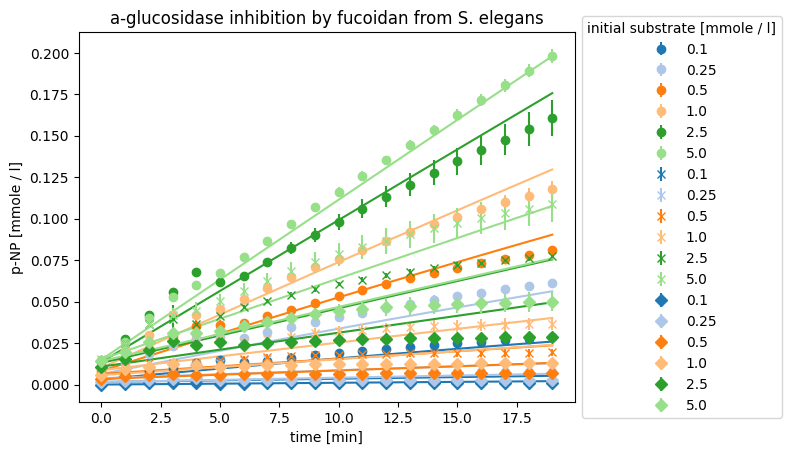

In [14]:
kinetics = []
for enzmldoc in enzml_docs:
    result = ParameterEstimator.from_EnzymeML(enzmldoc=enzmldoc,reactant_id="s1", inhibitor_id="s2", measured_species="product")
    result.fit_models()
    kinetics.append(result)
    result.visualize(plot_means=True)
    plt.show()

## $k_{cat}$ and $K_{m}$



In [13]:
# Get kinetic parameters of all datasets
kcat = []
kcat_std = []
Km = []
Km_std = []
corr_kcat_km = []
for result in kinetics:
    params = result.get_parameter_dict()

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)


    correlation = params["k_cat"].correl
    if correlation == None:
        corr_kcat_km.append(float("nan"))
    else:
        corr_kcat_km.append(correlation["Km"])


df = pd.DataFrame.from_dict({
    'kcat [1/min]':kcat, 
    'kcat stderr':kcat_std, 
    'Km [mM]':Km, 
    'Km stderr':Km_std, 
    "correlation kcat/Km":corr_kcat_km})

df


,kcat [1/min],kcat stderr,Km [mM],Km stderr,correlation kcat/Km
0,1650.543562,68.567687,0.537270,0.080309,-0.434760
1,1768.422752,102.033022,1.461047,0.200855,0.912771
2,1089.309474,15.733598,0.676981,0.031014,0.826747
3,1474.870342,11.446200,1.260928,0.025848,0.893857
4,824.901555,5.351402,0.510622,0.012484,0.722688
5,1163.327292,17.444942,0.916960,0.039877,0.861308


In [5]:
enzmldoc = enzml_docs[0]

del enzmldoc.measurement_dict["m6"]
del enzmldoc.measurement_dict["m7"]
del enzmldoc.measurement_dict["m8"]
del enzmldoc.measurement_dict["m9"]
del enzmldoc.measurement_dict["m10"]
del enzmldoc.measurement_dict["m11"]
del enzmldoc.measurement_dict["m12"]
del enzmldoc.measurement_dict["m13"]
del enzmldoc.measurement_dict["m14"]
del enzmldoc.measurement_dict["m15"]
del enzmldoc.measurement_dict["m16"]
del enzmldoc.measurement_dict["m17"]

In [6]:
kinetics = ParameterEstimator.from_EnzymeML(
    enzmldoc=enzmldoc,
    reactant_id="s1",
    measured_species="product")

kinetics.fit_models(enzyme_inactivation=True)

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive product inhibition model
 - uncompetitive product inhibition model
 - non-competitive product inhibition model
 - substrate inhibition model


,AIC,kcat [1/min],Km [mmole / l],ki time-dep enzyme-inactiv. [1/min],kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
competitive product inhibition,-2257,1879.010 +/- 2.96%,0.398 +/- 11.56%,0.023 +/- 24.42%,4716.196 +/- 11.93%,0.065 +/- 32.40%,-
non-competitive product inhibition,-2255,2477.180 +/- 24.37%,0.544 +/- 30.17%,0.000 +/- 3906.23%,4554.158 +/- 38.78%,0.040 +/- 39.86%,0.251 +/- 99.55%
irreversible Michaelis Menten,-2231,1883.439 +/- 2.90%,0.582 +/- 4.10%,0.043 +/- 10.25%,3234.668 +/- 5.03%,-,-
uncompetitive product inhibition,-2229,1883.604 +/- 3.08%,0.582 +/- 4.11%,0.043 +/- 10.34%,3234.343 +/- 5.14%,-,844.290 +/- 4979.17%
substrate inhibition,-2227,1892.295 +/- 3.08%,0.587 +/- 4.17%,0.043 +/- 11.03%,3222.920 +/- 5.18%,-,999.940 +/- 156.07%


In [7]:
kinetics.fit_models(
    enzyme_inactivation=True, 
    start_time_index=8,
    initial_substrate_concs=[0.1, 0.25, 0.5, 1, 5])

Fitting data to:
 - irreversible Michaelis Menten model
 - competitive product inhibition model
 - uncompetitive product inhibition model
 - non-competitive product inhibition model
 - substrate inhibition model


,AIC,kcat [1/min],Km [mmole / l],ki time-dep enzyme-inactiv. [1/min],kcat / Km [1/min * 1/mmole / l],Ki competitive [mmole / l],Ki uncompetitive [mmole / l]
competitive product inhibition,-1367,1807.855 +/- 3.09%,0.660 +/- 8.33%,0.018 +/- 42.60%,2738.363 +/- 8.88%,0.145 +/- 28.45%,-
non-competitive product inhibition,-1365,1808.173 +/- 17.82%,0.660 +/- 19.81%,0.018 +/- 54.17%,2738.303 +/- 26.65%,0.145 +/- 35.04%,954.402 +/- 86749.69%
irreversible Michaelis Menten,-1342,1716.141 +/- 3.08%,0.907 +/- 3.62%,0.032 +/- 25.03%,1892.619 +/- 4.75%,-,-
uncompetitive product inhibition,-1340,1716.422 +/- 3.14%,0.907 +/- 4.10%,0.032 +/- 26.29%,1892.485 +/- 5.17%,-,999.612 +/- 10450.38%
substrate inhibition,-1339,1725.403 +/- 4.13%,0.914 +/- 5.89%,0.032 +/- 25.24%,1886.983 +/- 7.19%,-,999.998 +/- 575.44%


Fit report for irreversible Michaelis Menten model
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 117
    # variables        = 3
    chi-square         = 0.00116138
    reduced chi-square = 1.0188e-05
    Akaike info crit   = -1341.87794
    Bayesian info crit = -1333.59141
[[Variables]]
    k_cat:  1716.14120 +/- 52.8030058 (3.08%) (init = 3652.667)
    Km:     0.90675489 +/- 0.03286791 (3.62%) (init = 1.6784)
    K_ie:   0.03177073 +/- 0.00795342 (25.03%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_ie) = 0.883
    C(Km, K_ie)    = -0.210
    C(k_cat, Km)   = 0.198


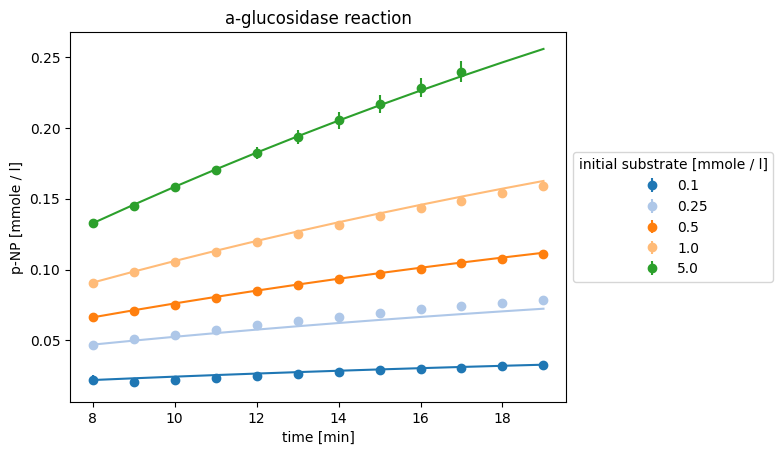

In [8]:
kinetics.visualize(model_name="irreversible Michaelis Menten", title="a-glucosidase reaction")